# 특징점 추출을 통해 카드 이미지를 인식
opencv의 ORB 특징점 추출 및 매칭을 통해 카메라 이미지로부터 영웅 카드를 인식합니다. 먼저 특징점이 어떻게 매칭되었는지 이미지로 확인하고, 각 템플릿 이미지에 따라 매칭점의 수가 어떻게 바뀌는지, framerate는 얼마나 나오는지 등을 확인하여 실시간 동영상에 적용해보도록 하겠습니다.

In [1]:
## 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# 단일 이미지 간 특징점 매칭
템플릿 이미지와 3장의 사진을 매칭해봅니다. 3장의 사진은 모두 템플릿 이미지가 포함된 왜곡된 이미지이며, ORB를 통해 특징점을 추출하고 FLANN을 통해 매칭된 결과를 이미지로 출력합니다.

ORB는 Oriented FAST and Rotated BRIEF의 준말로, FAST-9 알고리즘을 적용하여 keypoint를 추출한 뒤, BRIEF 알고리즘을 이용하여 descriptor를 생성합니다. ORB는 저전력의 단말기에서도 잘 작동한다고 합니다. FAST-9 알고리즘은 주변부 9개 픽셀의 밝기를 이용하여 특징점을 추출하기 때문에 도트 이미지에 적합하다고 생각했습니다.

FLANN은 Fast Library for Approximate Nearest Neighbors의 준말로, 특징점 매칭을 위한 라이브러리입니다. 각 이미지 특징점을 전수조사하는 방식인 BF(Brute Force)와 비교했을 때, 이미지 크기가 커져 특징점이 많아질수록 FLANN 방식의 특징점 매칭이 효율적입니다.


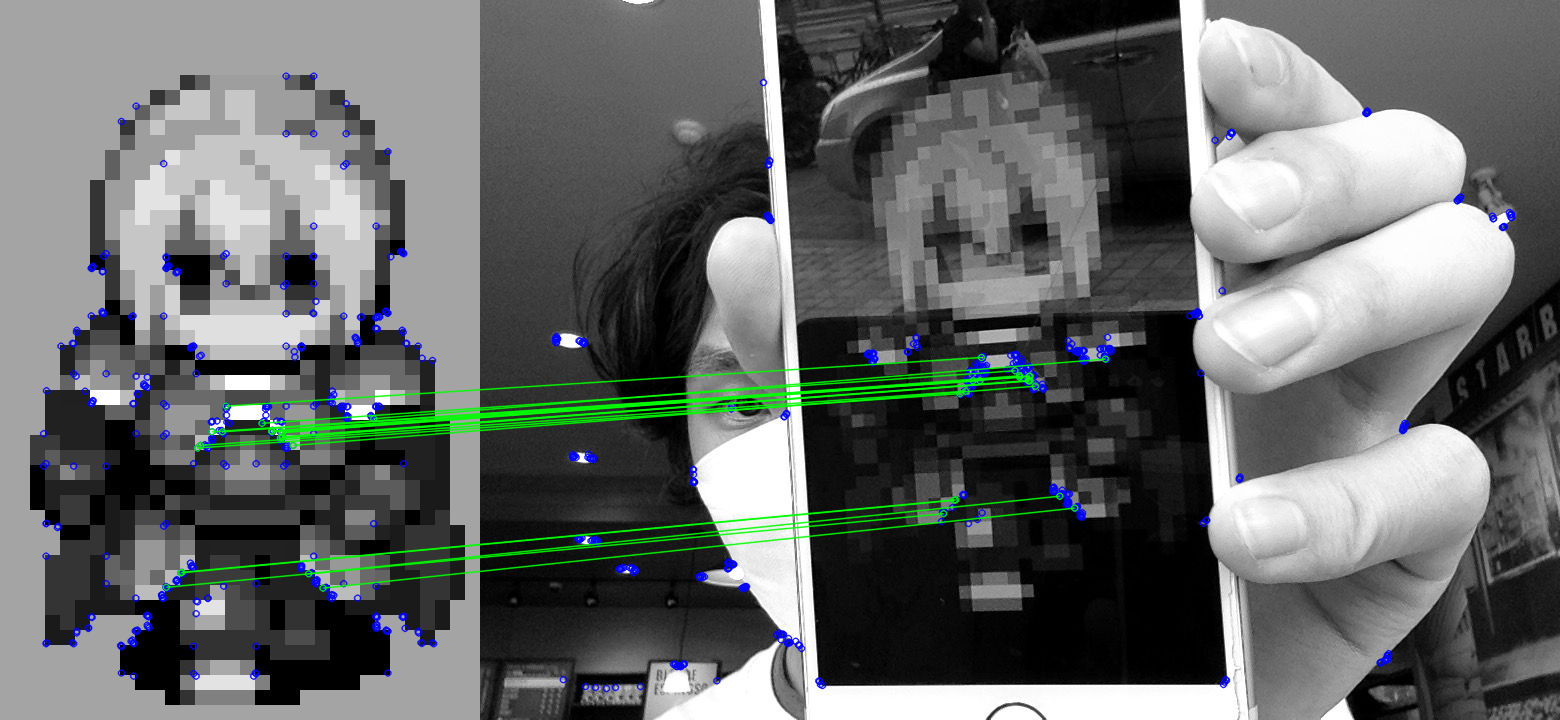

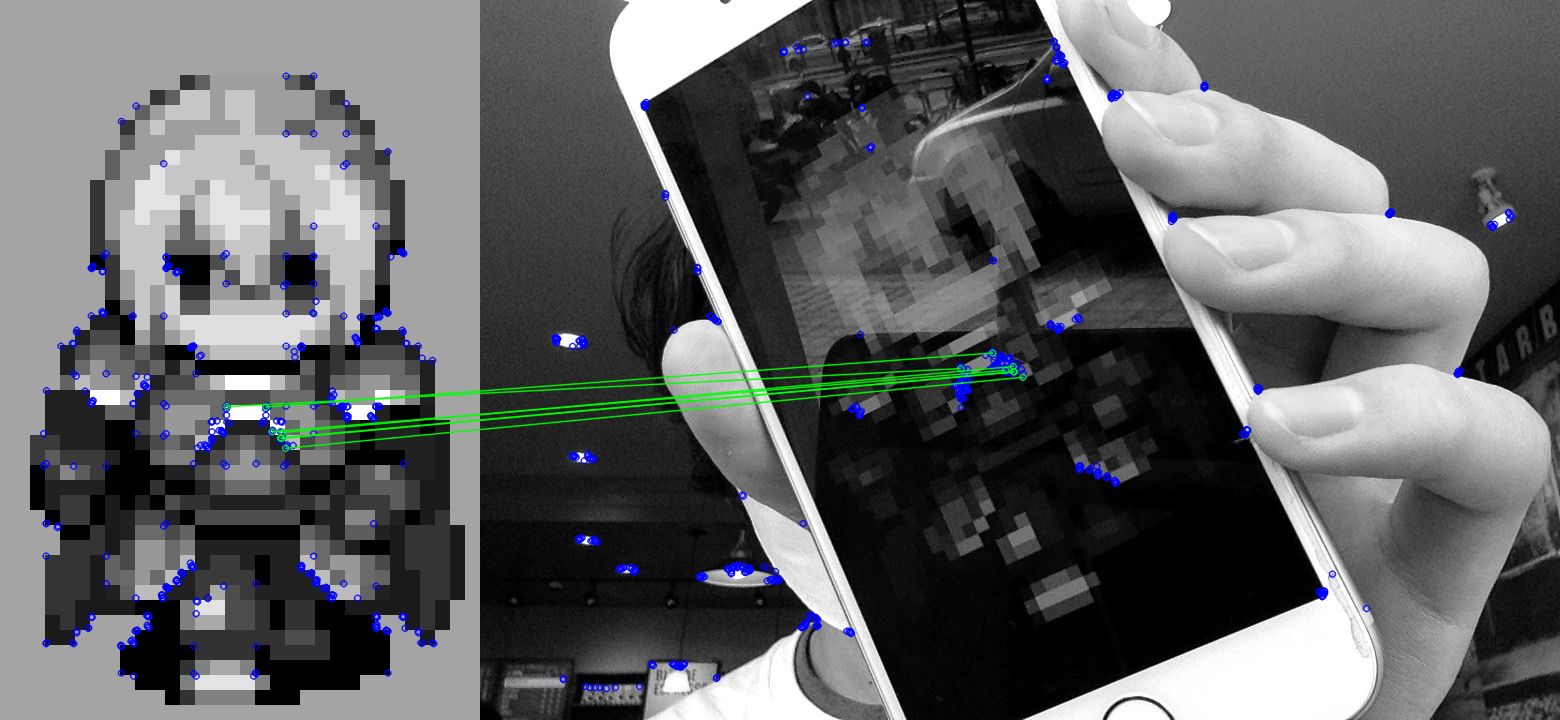

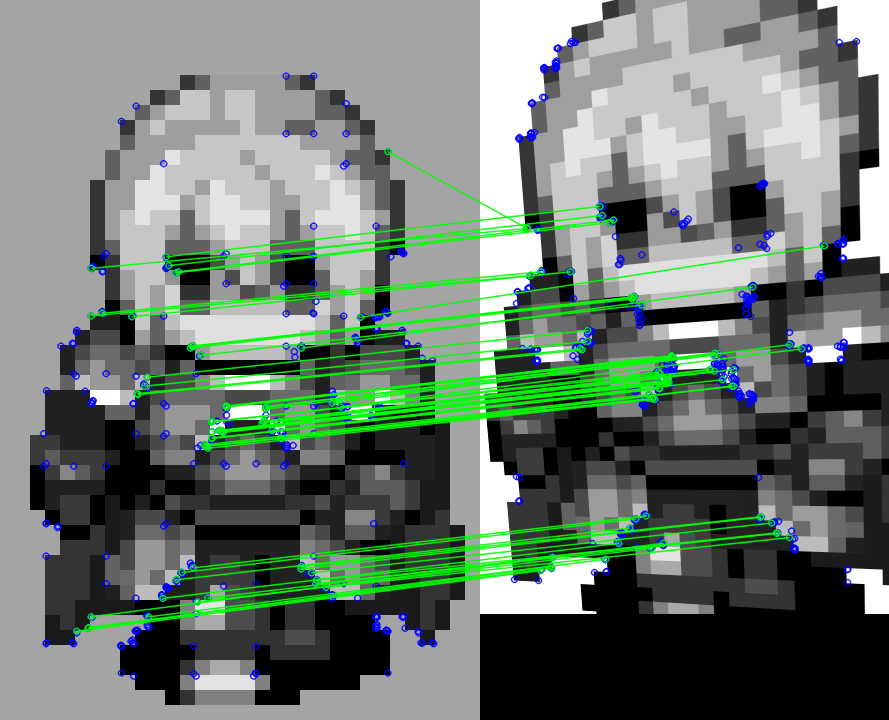

In [ ]:
# 단일 이미지 간 특징점 매칭
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

## 작업 경로 설정
workspace = '/content/drive/My Drive/돈과 유명세를 잡자/Zumi/recognize_test/{filename}' # {filename} 앞 경로를 리소스가 존재하는 경로로 변경하세요.
templatePath = workspace.format(filename='Hero 1.png')
srcPath = workspace.format(filename='capture {num}.jpg')

# 특징점 추출 알고리즘
orb = cv2.ORB_create()
# 템플릿 이미지 불러오기
template = cv2.imread(templatePath, cv2.IMREAD_GRAYSCALE)
# 이미지 keypoint, descriptor 추출
kp1, des1 = orb.detectAndCompute(template, mask=None)

# ORB를 위한 FLANN 설정값
FLANN_INDEX_LSH = 6
indexParams = dict(algorithm=FLANN_INDEX_LSH, table_number=6, key_size=12, multi_probe_level=1)
searchParams = dict(checks=20)
# 특징점 매칭 알고리즘
flann = cv2.FlannBasedMatcher(indexParams, searchParams)

# 3개의 캡쳐 이미지에 대해
for num in range(1, 4):
  # 이미지 로드 및 특징점 추출
  src = cv2.imread(srcPath.format(num=num), cv2.IMREAD_GRAYSCALE)
  kp2, des2 = orb.detectAndCompute(src, mask=None)

  # 두 이미지 간의 특징점 매칭
  matches = flann.knnMatch(des1, des2, k=2)
  matchesMask = [[0, 0] for i in range(len(matches))]
  for i, mn in enumerate(matches):
    # 1~2순위 특정 불가인 경우 예외 처리
    if len(mn) < 2: continue
    m, n = mn
    # 1순위 매칭 결과가 0.55 * 2순위 매칭 결과보다 작은 경우만 취급
    if m.distance < 0.55 * n.distance:
      matchesMask[i] = [1, 0]

  # 이미지 출력을 위한 설정
  draw_params = dict(matchColor=(0, 255, 0),
                    singlePointColor=(255, 0, 0),
                    matchesMask=matchesMask,
                    flags=cv2.DrawMatchesFlags_DEFAULT)
  
  # 두 이미지, 특징점, 매칭된 점 간 엣지를 합친 이미지
  dst = cv2.drawMatchesKnn(template, kp1, src, kp2, matches, outImg=None, **draw_params)
  cv2_imshow(dst)

# 정지 이미지에서 Top 5 템플릿 이미지 탐색
위 예제에서는 템플릿 이미지가 하나이기 때문에 이미지 인식의 정확한 성능은 확인할 수 없었습니다. 이번에는 104개의 템플릿 이미지에서 매칭된 특징점 순으로 상위 5개 템플릿의 ID와 이미지를 출력해보겠습니다.

In [ ]:
# 정지 이미지에서 Top 5 템플릿 이미지 탐색
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

## 작업 경로 설정
workspace = '/content/drive/My Drive/돈과 유명세를 잡자/Zumi/recognize_test/{filename}' # {filename} 앞 경로를 리소스가 존재하는 경로로 변경하세요.
templatePath = workspace.format(filename='Hero {num}.png')
srcPath = workspace.format(filename='capture 1.jpg')

# 특징점 추출 알고리즘
orb = cv2.ORB_create()
# 템플릿 이미지 로드 및 특징점 추출
templates_kp = []
templates_des = []
for num in range(1, 105):
  template = cv2.imread(templatePath.format(num=num), cv2.IMREAD_GRAYSCALE)
  kp, des = orb.detectAndCompute(template, mask=None)
  templates_kp.append(kp)
  templates_des.append(des)

# 소스 이미지 불러오기
src = cv2.imread(srcPath, cv2.IMREAD_GRAYSCALE)
# 이미지 keypoint, descriptor 추출
kp2, des2 = orb.detectAndCompute(src, mask=None)

# ORB를 위한 FLANN 설정값
FLANN_INDEX_LSH = 6
indexParams = dict(algorithm=FLANN_INDEX_LSH, table_number=6, key_size=12, multi_probe_level=1)
searchParams = dict(checks=20)
# FLANN(Fast Library for Approximate Nearest Neighbors): 특징점 매칭을 위한 라이브러리
flann = cv2.FlannBasedMatcher(indexParams, searchParams)

top 1: idx: 0, cnt: 17


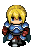

top 2: idx: 4, cnt: 3


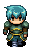

top 3: idx: 58, cnt: 2


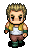

top 4: idx: 43, cnt: 2


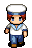

top 5: idx: 36, cnt: 2


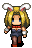

In [ ]:
cnt_idx_arr = []
# 104개의 특징점에 대해 반복
for idx, des1 in enumerate(templates_des):
  # 두 이미지 간의 특징점 매칭
  matches = flann.knnMatch(des1, des2, k=2)
  # 유력 특징점의 수
  cnt = 0
  # 매칭된 특징점에 대해 반복
  for i, mn in enumerate(matches):
    # 예외 처리: 1~2순위 특징점이 없는 경우
    if len(mn) < 2: continue
    m, n = mn

    # 1순위 매칭 결과가 0.55 * 2순위 매칭 결과보다 작은 경우만 취급
    if m.distance < 0.55 * n.distance:
      cnt += 1

  cnt_idx_arr.append((cnt, idx))

for idx, (cnt, num) in enumerate(sorted(cnt_idx_arr, reverse=True)[:5]):
  print("top {i}: idx: {num}, cnt: {cnt}".format(i=idx+1, num=num, cnt=cnt))
  dst = cv2.imread(templatePath.format(num=num+1), cv2.IMREAD_UNCHANGED)
  dst = cv2.resize(dst, (32, 48))
  cv2_imshow(dst)

In [ ]:
# 성능 측정
def match_5():
  cnt_idx_arr = []
  # 104개의 특징점에 대해 반복
  for idx, des1 in enumerate(templates_des):
    # 두 이미지 간의 특징점 매칭
    matches = flann.knnMatch(des1, des2, k=2)
    # 유력 특징점의 수
    cnt = 0
    # 매칭된 특징점에 대해 반복
    for i, mn in enumerate(matches):
      # 예외 처리: 1~2순위 특징점이 없는 경우
      if len(mn) < 2: continue
      m, n = mn

      # 1순위 매칭 결과가 0.55 * 2순위 매칭 결과보다 작은 경우만 취급
      if m.distance < 0.55 * n.distance:
        cnt += 1

    cnt_idx_arr.append((cnt, idx))

  print(sorted(cnt_idx_arr, reverse=True)[:5])

%timeit match_5()

[(19, 0), (3, 58), (3, 4), (2, 50), (2, 36)]
[(15, 0), (2, 58), (2, 43), (2, 42), (2, 36)]
[(18, 0), (3, 4), (2, 86), (2, 58), (2, 36)]
[(17, 0), (3, 4), (2, 81), (2, 58), (2, 36)]
[(18, 0), (3, 4), (2, 84), (2, 58), (2, 36)]
[(19, 0), (4, 58), (3, 42), (3, 4), (2, 43)]
[(16, 0), (3, 47), (3, 43), (3, 4), (3, 3)]
[(15, 0), (3, 58), (2, 62), (2, 39), (2, 36)]
[(16, 0), (2, 86), (2, 82), (2, 58), (2, 45)]
[(16, 0), (3, 58), (2, 82), (2, 42), (2, 36)]
[(16, 0), (2, 58), (2, 47), (2, 43), (2, 36)]
[(16, 0), (2, 58), (2, 42), (2, 36), (2, 29)]
[(16, 0), (3, 84), (3, 4), (2, 82), (2, 58)]
[(14, 0), (2, 58), (2, 36), (2, 15), (2, 12)]
[(19, 0), (4, 4), (3, 84), (3, 36), (2, 82)]
[(19, 0), (3, 4), (2, 63), (2, 58), (2, 47)]
[(17, 0), (3, 4), (2, 81), (2, 65), (2, 58)]
[(16, 0), (2, 82), (2, 61), (2, 58), (2, 42)]
[(18, 0), (2, 83), (2, 58), (2, 43), (2, 36)]
[(15, 0), (3, 42), (2, 75), (2, 58), (2, 36)]
[(17, 0), (4, 4), (2, 84), (2, 82), (2, 68)]
[(15, 0), (2, 82), (2, 65), (2, 58), (2, 42)]


#  데이터 셋 크기 별 성능 측정
성능이 대략 170 ~ 180ms per loop으로 측정됩니다. 1초에 6장 정도의 성능으로는 주미가 주행 중 카드를 발견했을 때 멈춰서지 않고 부딪칠 것으로 예상됩니다. 데이터 셋의 크기가 다를 경우 성능이 얼마나 차이나는지 측정하도록 하겠습니다.

In [ ]:
# 데이터 셋 크기 별 성능 측정
def match(end):
  cnt_idx_arr = []
  # 104개의 특징점에 대해 반복
  for idx, des1 in enumerate(templates_des[:-end]):
    # 두 이미지 간의 특징점 매칭
    matches = flann.knnMatch(des1, des2, k=2)
    # 유력 특징점의 수
    cnt = 0
    # 매칭된 특징점에 대해 반복
    for i, mn in enumerate(matches):
      # 예외 처리: 1~2순위 특징점이 없는 경우
      if len(mn) < 2: continue
      m, n = mn

      # 1순위 매칭 결과가 0.55 * 2순위 매칭 결과보다 작은 경우만 취급
      if m.distance < 0.55 * n.distance:
        cnt += 1

    cnt_idx_arr.append((cnt, idx))

for i in range(0, 104, 10):
  print("dataset size: " + str(104-i))
  %timeit match(i)
  print()

dataset size: 104
The slowest run took 7.03 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 3: 594 ns per loop

dataset size: 94
10 loops, best of 3: 158 ms per loop

dataset size: 84
10 loops, best of 3: 141 ms per loop

dataset size: 74
10 loops, best of 3: 124 ms per loop

dataset size: 64
10 loops, best of 3: 107 ms per loop

dataset size: 54
10 loops, best of 3: 92.1 ms per loop

dataset size: 44
10 loops, best of 3: 75.7 ms per loop

dataset size: 34
10 loops, best of 3: 57.3 ms per loop

dataset size: 24
10 loops, best of 3: 40.3 ms per loop

dataset size: 14
10 loops, best of 3: 24 ms per loop

dataset size: 4
100 loops, best of 3: 6.92 ms per loop



# False 이미지 성능 측정
다음으로, 일정 수준 이하의 특징점이 매칭되면 템플릿을 검출하지 않도록 만들기 위해, 템플릿 이미지가 나타나지 않은 이미지를 대상으로 특징점 매칭을 진행하겠습니다. 실험 결과 4개 이하의 특징점이 검출되었지만, 혹시 모를 상황을 위해 특징점이 10개 미만인 경우에는 해당 이미지를 무시하기로 하겠습니다.

In [ ]:
# False 이미지
for i in range(4, 10):
  srcPath = workspace.format(filename='capture %d.jpg' % i)
  src = cv2.imread(srcPath, cv2.IMREAD_GRAYSCALE)
  kp2, des2 = orb.detectAndCompute(src, mask=None)
  %timeit match_5()

[(1, 98), (1, 95), (1, 73), (1, 71), (1, 29)]
[(1, 67), (1, 65), (1, 49), (1, 35), (1, 34)]
[(1, 89), (1, 88), (1, 73), (1, 65), (1, 62)]
[(1, 73), (1, 65), (1, 56), (1, 29), (1, 17)]
[(3, 3), (1, 103), (1, 88), (1, 29), (1, 14)]
[(1, 99), (1, 89), (1, 72), (1, 55), (1, 53)]
[(1, 103), (1, 101), (1, 95), (1, 89), (1, 82)]
[(2, 14), (1, 79), (1, 76), (1, 44), (1, 29)]
[(1, 103), (1, 31), (1, 29), (1, 4), (1, 3)]
[(1, 93), (1, 89), (1, 67), (1, 34), (1, 29)]
[(2, 10), (1, 102), (1, 90), (1, 89), (1, 76)]
[(1, 103), (1, 101), (1, 46), (1, 29), (1, 4)]
[(1, 84), (1, 67), (1, 29), (1, 4), (1, 3)]
[(1, 103), (1, 89), (1, 71), (1, 46), (1, 45)]
[(1, 94), (1, 90), (1, 72), (1, 67), (1, 32)]
[(1, 67), (1, 54), (1, 33), (1, 29), (1, 4)]
[(1, 29), (1, 4), (1, 3), (0, 103), (0, 102)]
[(2, 3), (1, 67), (1, 29), (1, 12), (1, 4)]
[(1, 79), (1, 71), (1, 67), (1, 29), (1, 25)]
[(1, 76), (1, 67), (1, 29), (1, 4), (1, 3)]
[(2, 3), (1, 58), (1, 29), (1, 4), (0, 103)]
[(1, 90), (1, 76), (1, 67), (1, 29), (

# 템플릿 특징점 저장
특징점을 매칭할 때마다 매번 템플릿 이미지를 불러와서 특징점을 추출하는 것은 비효율적입니다. 이번에는 템플릿 이미지에서 추출한 특징점을 파일로 저장하고 다시 불러오기까지 해보도록 하겠습니다.

In [ ]:
# 템플릿 특징점 추출
import cv2
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

# 작업 경로 설정
workspace = '/content/drive/My Drive/돈과 유명세를 잡자/Zumi/recognize_test/{filename}' # {filename} 앞 경로를 리소스가 존재하는 경로로 변경하세요.
templatePath = workspace.format(filename='Hero {num}.png')

# 특징점 추출 알고리즘
orb = cv2.ORB_create()

# 템플릿 이미지 로드 및 특징점 추출
descriptors = []
for num in range(1, 105):
  template = cv2.imread(templatePath.format(num=num), cv2.IMREAD_GRAYSCALE)
  kp, des = orb.detectAndCompute(template, mask=None)
  descriptors.append(des)

np.save(workspace.format(filename='template.npy'), descriptors)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


top 1: idx: 0, cnt: 18


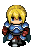

top 2: idx: 58, cnt: 3


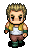

top 3: idx: 81, cnt: 2


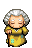

top 4: idx: 64, cnt: 2


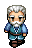

top 5: idx: 42, cnt: 2


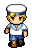

In [ ]:
# 저장된 템플릿 디스크립터로 정지 이미지에서 Top 5 템플릿 이미지 탐색
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

## 작업 경로 설정
workspace = '/content/drive/My Drive/돈과 유명세를 잡자/Zumi/recognize_test/{filename}' # {filename} 앞 경로를 리소스가 존재하는 경로로 변경하세요.
srcPath = workspace.format(filename='capture 1.jpg')

# 특징점 추출 알고리즘
orb = cv2.ORB_create()
# 템플릿 이미지 로드 및 특징점 추출
descriptors = np.load(workspace.format(filename='template.npy'), allow_pickle=True)

# 소스 이미지 불러오기
src = cv2.imread(srcPath, cv2.IMREAD_GRAYSCALE)
# 이미지 keypoint, descriptor 추출
kp2, des2 = orb.detectAndCompute(src, mask=None)

# ORB를 위한 FLANN 설정값
FLANN_INDEX_LSH = 6
indexParams = dict(algorithm=FLANN_INDEX_LSH, table_number=6, key_size=12, multi_probe_level=1)
searchParams = dict(checks=20)
# FLANN(Fast Library for Approximate Nearest Neighbors): 특징점 매칭을 위한 라이브러리
flann = cv2.FlannBasedMatcher(indexParams, searchParams)

cnt_idx_arr = []
# 104개의 특징점에 대해 반복
for idx, des1 in enumerate(descriptors):
  # 두 이미지 간의 특징점 매칭
  matches = flann.knnMatch(des1, des2, k=2)
  # 유력 특징점의 수
  cnt = 0
  # 매칭된 특징점에 대해 반복
  for i, mn in enumerate(matches):
    # 예외 처리: 1~2순위 특징점이 없는 경우
    if len(mn) < 2: continue
    m, n = mn

    # 1순위 매칭 결과가 0.55 * 2순위 매칭 결과보다 작은 경우만 취급
    if m.distance < 0.55 * n.distance:
      cnt += 1

  cnt_idx_arr.append((cnt, idx))

for idx, (cnt, num) in enumerate(sorted(cnt_idx_arr, reverse=True)[:5]):
  print("top {i}: idx: {num}, cnt: {cnt}".format(i=idx+1, num=num, cnt=cnt))
  dst = cv2.imread(templatePath.format(num=num+1), cv2.IMREAD_UNCHANGED)
  dst = cv2.resize(dst, (32, 48))
  cv2_imshow(dst)

# 추가사항:
아래 셀 두 개를 이용하여 google drive에 cpp 파일을 작성하고, 컴파일 및 실행할 수 있습니다. 이를 이용하여 colab 상에서 opencv c++ 예제를 작성하는 것도 가능할 것으로 보입니다. 물론, GUI를 사용할 수 없기 때문에 이미지 표시는 할 수 없습니다. 다음 시간에는 C++을 활용하여 실시간 동영상에 위 방법을 적용해보도록 하겠습니다.


In [51]:
%%writefile test.cpp
#include <iostream>
#include <opencv2/opencv.hpp>

using namespace cv;
using namespace std;
 
int main(int argc, const char * argv[]) {
    // Create a VideoCapture object to read from video file
    string workspace = "/content/drive/My Drive/돈과 유명세를 잡자/Zumi/recognize_test/";
    string srcPath = workspace.append("Hero 1.png");

    Mat frame = imread(srcPath, IMREAD_UNCHANGED);
    cout << frame.size().width << ' ' << frame.size().height << ' ' << frame.channels() << ' ' << frame.type() << endl;
    return 0;
}

Overwriting test.cpp


In [52]:
%%script bash
g++ -ggdb test.cpp -o test `pkg-config --cflags --libs opencv` && ./test

480 720 4 24


# 출처:
- ORB: http://www.gisdeveloper.co.kr/?p=6821
- FAST: https://m.blog.naver.com/samsjang/220655420471
- FLANN: https://m.blog.naver.com/samsjang/220657746860
- np.load: https://d-tail.tistory.com/31
- colab c++: https://blog.abivin.vn/2020/01/how-to-use-google-colab-to-run-c-code.html